# ResNet for Time Series Classification

### Import libraries

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import shutil
import sys

import keras_tuner
from tensorflow import keras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

import warnings
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2.6.4


In [2]:
# Random seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
def Unroll2D(X,Y):
    # Store the shape of the input array X
    initialShape = X.shape

    # Flatten the 3D array X into a 2D array
    X_flat = X.reshape(initialShape[0]*initialShape[1],initialShape[2])

    # Get the unique values and counts of the 1D array Y
    classes, classes_count = np.unique(Y, return_counts=True)

    # Calculate the number of elements in each class
    elPerClass = classes_count*initialShape[1]

    # Initialize an empty 1D array for the output Y
    Y_flat = np.empty(0)

    i=0 
    #Build a new Y to match the unrolled dataset
    # Iterate over the number of elements in each class
    for el in elPerClass:
        # Append the label for each element in the current class
        for y in range(el):
            Y_flat=np.append(Y_flat,i)
        # Increment the label for the next class
        i=i+1

    # Verify that all is correct by comparing the counts of the unique values
    # in the output Y with the expected number of elements in each class
    classes, classes_count_post = np.unique(Y_flat, return_counts=True)
    assert classes_count_post.all()==elPerClass.all() 

    # Return the flattened X and Y arrays
    return X_flat, Y_flat

### Exploration Data Analysis (EDA)

In [4]:
# Define a function to inspect NumPy arrays
def describe_array(np_array,name):
    print("DESCRIBE "+name.upper())
    print("Dimensions:",np_array.ndim)
    print("Shape:",np_array.shape,"\n")

In [5]:
X_Dataset = np.load("/kaggle/input/an2dl-challenge2/x_train.npy")
Y_Dataset = np.load("/kaggle/input/an2dl-challenge2/y_train.npy")

describe_array(X_Dataset,"X_train")
describe_array(Y_Dataset,"Y_train")

DESCRIBE X_TRAIN
Dimensions: 3
Shape: (2429, 36, 6) 

DESCRIBE Y_TRAIN
Dimensions: 1
Shape: (2429,) 



In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Dataset, Y_Dataset, test_size=0.2, stratify = Y_Dataset)

In [7]:
describe_array(X_train,"trainX")
describe_array(Y_train,"trainY")
print()
describe_array(X_val,"valX")
describe_array(Y_val,"valY")

DESCRIBE TRAINX
Dimensions: 3
Shape: (1943, 36, 6) 

DESCRIBE TRAINY
Dimensions: 1
Shape: (1943,) 


DESCRIBE VALX
Dimensions: 3
Shape: (486, 36, 6) 

DESCRIBE VALY
Dimensions: 1
Shape: (486,) 



In [8]:
label_mapping = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine"
}

In [9]:
# Apply RobustScaler to the useful features
Xt,Yt=Unroll2D(X_train,Y_train)
Xv,Yv=Unroll2D(X_val,Y_val)

scaler = RobustScaler()
scaler = scaler.fit(Xt)

X_train = scaler.transform(Xt).reshape(X_train.shape)
X_val = scaler.transform(Xv).reshape(X_val.shape)

In [10]:
# To save the scaler parameters
if not os.path.exists('/kaggle/working/export.obj'):
    import pickle 
    import math 
    
    filehandler = open('export.obj', 'wb') 
    pickle.dump(scaler, filehandler)
    filehandler.close()

In [11]:
# Convert the sparse labels to categorical values
Y_train = tfk.utils.to_categorical(Y_train)
Y_val = tfk.utils.to_categorical(Y_val)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1943, 36, 6), (1943, 12), (486, 36, 6), (486, 12))

# Build and train models

In [12]:
input_shape = X_train.shape[1:]
classes = Y_train.shape[-1]
batch_size = 64
epochs = 1000

## ResNet Conv1D

In [13]:
def build_model_resnet(input_shape, nb_classes):
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(input_layer)
    conv_x = keras.layers.Activation('relu')(conv_x)
    conv_x = tfkl.Dropout(0.4, seed=seed)(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.Activation('relu')(conv_y)
    conv_y = tfkl.Dropout(0.4, seed=seed)(conv_y)
    
    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = tfkl.Dropout(0.4, seed=seed)(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_y])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)
    
    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(output_block_1)
    conv_x = keras.layers.Activation('relu')(conv_x)
    conv_x = tfkl.Dropout(0.4, seed=seed)(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.Activation('relu')(conv_y)
    conv_y = tfkl.Dropout(0.4, seed=seed)(conv_y)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = tfkl.Dropout(0.4, seed=seed)(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_y])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)
    
    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(output_block_2)
    conv_x = keras.layers.Activation('relu')(conv_x)
    conv_x = tfkl.Dropout(0.4, seed=seed)(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.Activation('relu')(conv_y)
    conv_y = tfkl.Dropout(0.4, seed=seed)(conv_y)

    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_2)
    shortcut_y = tfkl.Dropout(0.4, seed=seed)(shortcut_y)

    output_block_3 = keras.layers.add([conv_y, shortcut_y])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)
    
    # BLOCK 4

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 4, kernel_size=5, padding='same')(output_block_3)
    conv_x = keras.layers.Activation('relu')(conv_x)
    conv_x = tfkl.Dropout(0.4, seed=seed)(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 4, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.Activation('relu')(conv_y)
    conv_y = tfkl.Dropout(0.4, seed=seed)(conv_y)

    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 4, kernel_size=1, padding='same')(output_block_3)
    shortcut_y = tfkl.Dropout(0.4, seed=seed)(shortcut_y)

    output_block_4 = keras.layers.add([conv_y, shortcut_y])
    output_block_4 = keras.layers.Activation('relu')(output_block_4)
    
    # BLOCK 5

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 4, kernel_size=5, padding='same')(output_block_4)
    conv_x = keras.layers.Activation('relu')(conv_x)
    conv_x = tfkl.Dropout(0.4, seed=seed)(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 4, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.Activation('relu')(conv_y)
    conv_y = tfkl.Dropout(0.4, seed=seed)(conv_y)

    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 4, kernel_size=1, padding='same')(output_block_4)
    shortcut_y = tfkl.Dropout(0.4, seed=seed)(shortcut_y)

    output_block_5 = keras.layers.add([conv_y, shortcut_y])
    output_block_5 = keras.layers.Activation('relu')(output_block_5)
    
    # BLOCK 6

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 4, kernel_size=5, padding='same')(output_block_5)
    conv_x = keras.layers.Activation('relu')(conv_x)
    conv_x = tfkl.Dropout(0.4, seed=seed)(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 4, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.Activation('relu')(conv_y)
    conv_y = tfkl.Dropout(0.4, seed=seed)(conv_y)

    # no need to expand channels because they are equal
    output_block_6 = keras.layers.add([conv_y, output_block_5])
    output_block_6 = keras.layers.Activation('relu')(output_block_6)
    
    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_6)
    
    dropout = tfkl.Dropout(0.4, seed=seed)(gap_layer)

    # Classifier
    classifier = tfkl.Dense(256, activation=tfkl.LeakyReLU())(dropout)
    classifier = tfkl.Dropout(0.4, seed=seed)(classifier)

    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(classifier)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    return model

In [14]:
model = build_model_resnet(input_shape, classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 36, 64)       1984        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 36, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 36, 64)       0           activation[0][0]                 
______________________________________________________________________________________________

## Train The model 

In [ ]:
#mini_batch exploitation 
mini_batch_size = int(min(X_train.shape[0] / 10, batch_size))

# Train the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = mini_batch_size,
    epochs = epochs,
    verbose=2,
    validation_data = (X_val, Y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=60, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=0.0001)
    ]
).history

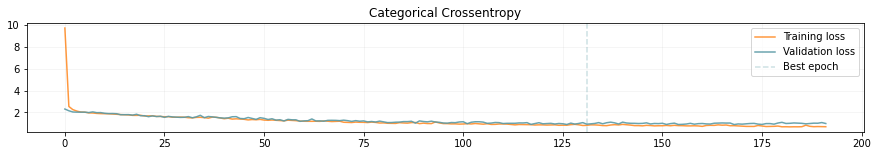

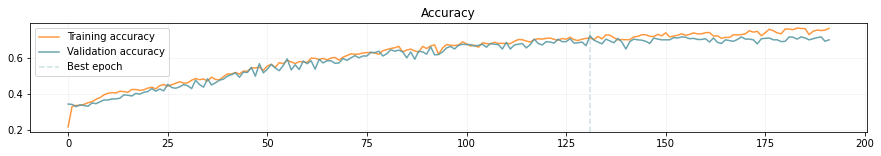

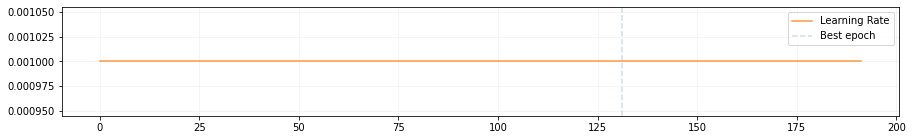

In [16]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(15,2))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

plt.figure(figsize=(15,2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

plt.figure(figsize=(15,2))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

In [ ]:
#prediction and evaluation is done on the Validation dataset
predictions = model.predict(X_val)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

print(classification_report(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), digits=3))
print()
print(cm.T)

# Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm.T, cmap='Oranges', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [18]:
def multiple_build_models(repetitions=3):
    models= []
    histories = []
    metrics = []
    confusion = []
    
    for i in range(repetitions): 
        print("sto trainando il modello numero: ",i)
        model = build_model_resnet(input_shape, classes)
        
        mini_batch_size = int(min(X_train.shape[0] / 10, batch_size))
        # Train the model
        history = model.fit(
            x = X_train,
            y = Y_train,
            batch_size = mini_batch_size,
            epochs = epochs,
            verbose=0,
            validation_data = (X_val, Y_val),
            callbacks = [
                tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=60, restore_best_weights=True),
                keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=0.0001)
            ]
        ).history

        predictions = model.predict(X_val)
        # Compute the confusion matrix
        cm = confusion_matrix(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1))

        # Compute the classification metrics
        accuracy = accuracy_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1))
        precision = precision_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
        recall = recall_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
        f1 = f1_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
        
        print('\tAccuracy:',accuracy.round(4))
        print('\tPrecision:',precision.round(4))
        print('\tRecall:',recall.round(4))
        print('\tF1:',f1.round(4),"\n")
        
        print(cm.T)
        print("\n\n")
        
        models.append(model)
        histories.append(history)
        metrics.append((accuracy.round(4),precision.round(4),recall.round(4),f1.round(4))) 
        confusion.append(cm) 
        
    return models,histories,metrics,confusion

In [ ]:
#train multiple time the same model to try overcome variability in models
models, histories, metrics, confusion_matrix = multiple_build_models(repetitions=5)

In [20]:
#save the model
name_model = 'ResNet_17_12_76'
models[0].save(name_model)
shutil.make_archive(name_model, 'zip', "./"+name_model)


'\nname_model = \'ResNet_17_12_76\'\nmodels[0].save(name_model)\n# model = tfk.models.load_model(\'LSTM\')\nshutil.make_archive(name_model, \'zip\', "./"+name_model)\n'